# Import modules

Download Multilingual KWS code

In [ ]:
!git clone https://github.com/harvard-edge/multilingual_kws/

Cloning into 'multilingual_kws'...
remote: Enumerating objects: 1200, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1200 (delta 97), reused 79 (delta 79), pack-reused 1088
Receiving objects: 100% (1200/1200), 19.75 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (770/770), done.


In [ ]:
import sys
sys.path.append("/content/multilingual_kws/")

from multilingual_kws.embedding import transfer_learning, input_data

import tensorflow as tf
import numpy as np
import IPython
from pathlib import Path
import matplotlib.pyplot as plt
import os
import subprocess
import csv
from tqdm.notebook import tqdm
import glob
import shutil
import pandas as pd
import sklearn.preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split

!pip install pydub
from pydub import AudioSegment

!pip install -q umap-learn
import umap

!apt-get -qq install opus-tools sox

# Download data

Positive examples (wake-word dataset)

Negative examples

In [ ]:
assets = [
  ("http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz", "/content/speech_commands")
, ("https://storage.googleapis.com/public-datasets-mswc/mswc_microset.tar.gz", "/content")
, ("https://storage.googleapis.com/public-datasets-mswc/audio/lv.tar.gz", "/content/mswc_lv")
, ("https://storage.googleapis.com/public-datasets-mswc/splits/lv.tar.gz", "/content/mswc_lv/lv")
, ("https://storage.googleapis.com/public-datasets-mswc/audio/lt.tar.gz", "/content/mswc_lt")
, ("https://storage.googleapis.com/public-datasets-mswc/splits/lt.tar.gz", "/content/mswc_lt/lt")
, ("https://storage.googleapis.com/public-datasets-mswc/audio/ru.tar.gz", "/content/mswc_ru")
, ("https://storage.googleapis.com/public-datasets-mswc/splits/ru.tar.gz", "/content/mswc_ru/ru")
, ("https://storage.googleapis.com/public-datasets-mswc/audio/et.tar.gz", "/content/mswc_et")
, ("https://storage.googleapis.com/public-datasets-mswc/splits/et.tar.gz", "/content/mswc_et/et")
, ("https://github.com/harvard-edge/multilingual_kws/releases/download/v0.1-alpha/multilingual_context_73_0.8011.tar.gz", "/content/embedding_model")
]
for asset,cache in assets:
    tf.keras.utils.get_file(origin=asset, untar=True, cache_subdir=cache)

2428936192/2428923189 [==============================] - 23s 0us/step


## Convert audio files

Convert unknown words, .opus to .wav

In [ ]:
SAMPLES_PER_LANGUAGE = 700

dest = Path("./converted")
if os.path.isdir(dest):
  shutil.rmtree(dest)

rng = np.random.RandomState(1)

for dir in ["./mswc_microset/en", "./mswc_lv/lv", "./mswc_lt/lt", "./mswc_ru/ru", "./mswc_et/et"]:
  samples = glob.glob(dir + "/clips/*/*.opus")
  samples = rng.choice(samples, SAMPLES_PER_LANGUAGE, replace=False)
  for s in samples:
    word = s.split("/")[-2]
    fname = s.split("/")[-1]
    destdir = dest / dir.split("/")[-1] / "clips" / word
    destdir.mkdir(parents=True, exist_ok=True)
    dest_file = str(destdir) + "/" + "".join(fname.split(".")[:-1]) + ".wav"
    print(dest_file)
    cmd = ["opusdec", "--rate", "16000", s, dest_file]
    subprocess.run(cmd)

converted/en/clips/down/common_voice_en_19709127.wav
converted/en/clips/learn/common_voice_en_120180.wav
converted/en/clips/one/common_voice_en_18481894.wav
converted/en/clips/three/common_voice_en_120958.wav
converted/en/clips/house/common_voice_en_17926067.wav
converted/en/clips/five/common_voice_en_179040.wav
converted/en/clips/six/common_voice_en_18736341.wav
converted/en/clips/dog/common_voice_en_529947__2.wav
converted/en/clips/bird/common_voice_en_420665.wav
converted/en/clips/four/common_voice_en_19707024.wav
converted/en/clips/house/common_voice_en_21388474.wav
converted/en/clips/two/common_voice_en_6234059.wav
converted/en/clips/two/common_voice_en_22404967.wav
converted/en/clips/five/common_voice_en_18754744.wav
converted/en/clips/two/common_voice_en_20386.wav
converted/en/clips/three/common_voice_en_22174972.wav
converted/en/clips/five/common_voice_en_21290010.wav
converted/en/clips/three/common_voice_en_19519438.wav
converted/en/clips/right/common_voice_en_20876360.wav
con

Generate "Tilde Tilde" negative samples

In [ ]:
tilde_samples = glob.glob("dataset/*/negative/1_*.wav")
for s in tilde_samples:
  dir, file_name = os.path.split(s)
  sound = AudioSegment.from_file(s)
  # duplicate 
  sound = sound + sound
  out_file = file_name.replace("1_", "3_")
  sound.export(f"{dir}/{out_file}", format="wav")

def listen(filepath):
    IPython.display.display(IPython.display.Audio(filename=filepath, rate="16000"))

listen(glob.glob("dataset/lv/negative/3_*.wav")[3])

Convert wakeword dataset samples to mono, sample rate = 16000, duration=1s

In [ ]:
samples = glob.glob("dataset/*/*/*.wav")
output_dir = "./converted"

for s in samples:
  out_file = output_dir + "/" + s
  Path(os.path.dirname(out_file)).mkdir(parents=True, exist_ok=True)
  #sound = AudioSegment.from_wav(s)
  sound = AudioSegment.from_file(s)
  sound = sound.set_channels(1)
  sound = sound.set_frame_rate(16000)
  # add silence to the beginning
  sound = AudioSegment.silent(duration=1000, frame_rate=16000) + sound
  # leave only last second
  sound = sound[-1000:]
  sound.export(out_file, format="wav")

noise_samples = glob.glob("dataset/noise/*.wav")

for s in noise_samples:
  out_file = output_dir + "/" + s
  Path(os.path.dirname(out_file)).mkdir(parents=True, exist_ok=True)
  sound = AudioSegment.from_file(s)
  sound = sound.set_channels(1)
  sound = sound.set_frame_rate(16000)
  # add silence to the beginning
  sound = AudioSegment.silent(duration=1000, frame_rate=16000) + sound
  # leave only last second
  sound = sound[-1000:]
  sound.export(out_file, format="wav")

## Far field augmentations

In [ ]:
!pip install audiomentations
!pip install pyroomacoustics

     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 1.1 MB 27.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.6.0-cp37-cp37m-linux_x86_64.whl size=9772354 sha256=e6f314ecf9c80512eee3497744b4c0ceddd005b5b26327aac3488427d83637c0
  Stored in directory: /root/.cache/pip/wheels/4f/4b/d9/089980483d6e617e61fceb2a0a94760d7beabc445bf0de761e
Successfully built pyroomacoustics


Download impulse responses

In [ ]:
!git clone https://github.com/RoyJames/room-impulse-responses
!mkdir -p rirs
!cd room-impulse-responses && ./get_mit.sh /content/rirs

Cloning into 'room-impulse-responses'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 60 (delta 22), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (60/60), done.
--2022-05-18 12:47:40--  https://mcdermottlab.mit.edu/Reverb/IRMAudio/Audio.zip
Resolving mcdermottlab.mit.edu (mcdermottlab.mit.edu)... 18.13.53.64
Connecting to mcdermottlab.mit.edu (mcdermottlab.mit.edu)|18.13.53.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11660005 (11M) [application/zip]
Saving to: ‘/content/rirs/Audio.zip’

Audio.zip           100%[===================>]  11.12M  46.0MB/s    in 0.2s    

2022-05-18 12:47:41 (46.0 MB/s) - ‘/content/rirs/Audio.zip’ saved [11660005/11660005]



Resample impulse responses to 16kHz

In [ ]:
import librosa    
import soundfile as sf

rirs = glob.glob("rirs/MIT_Survey/*.wav")

for r in rirs:
  y, s = librosa.load(r, sr=16000)
  sf.write(r, y, s)

Augument samples with random noise and reverb

In [ ]:
from audiomentations import Compose, AddGaussianNoise, ApplyImpulseResponse, RoomSimulator, Gain, PitchShift, Normalize, TimeStretch
import librosa
import soundfile as sf

MIN_MIC_DISTANCE=1
MAX_MIC_DISTANCE=3

samples = glob.glob("converted/dataset/*/*/*.wav")
output_dir = "./augmented"

augmenter_ir = Compose([
    ApplyImpulseResponse(ir_path="rirs", leave_length_unchanged=True, p=1)
])

augmenter_noise = Compose([
    AddGaussianNoise(p=1)
])

augmenter_noise_ir = Compose([
    AddGaussianNoise(p=1),
    ApplyImpulseResponse(ir_path="rirs", leave_length_unchanged=True, p=1)
])

augmenter_room = Compose([
    RoomSimulator(min_mic_distance=MIN_MIC_DISTANCE, max_mic_distance=MAX_MIC_DISTANCE, p=1)
])

augmenter_ir_room_noise = Compose([
    ApplyImpulseResponse(ir_path="rirs", leave_length_unchanged=True, p=1),    
    RoomSimulator(min_mic_distance=MIN_MIC_DISTANCE, max_mic_distance=MAX_MIC_DISTANCE, p=1),
    AddGaussianNoise(p=1)
])

augmenter_gain = Compose([
    Gain(min_gain_in_db=-30, max_gain_in_db=-20, p=1)
])

augmenter_gain_room = Compose([
    Gain(min_gain_in_db=-30, max_gain_in_db=-20, p=1),    
    RoomSimulator(min_mic_distance=MIN_MIC_DISTANCE, max_mic_distance=MAX_MIC_DISTANCE, p=1)
])

augmenter_gain_ir = Compose([
    Gain(min_gain_in_db=-30, max_gain_in_db=-20, p=1),
    ApplyImpulseResponse(ir_path="rirs", leave_length_unchanged=True, p=1),
])

augmenter_noise_room = Compose([
    AddGaussianNoise(p=1),
    RoomSimulator(min_mic_distance=MIN_MIC_DISTANCE, max_mic_distance=MAX_MIC_DISTANCE, p=1)
])

augmenter_room_gain = Compose([
    RoomSimulator(min_mic_distance=MIN_MIC_DISTANCE, max_mic_distance=MAX_MIC_DISTANCE, p=1),
    Gain(min_gain_in_db=-30, max_gain_in_db=-20, p=1)
])

augmenter_ir_room = Compose([
    ApplyImpulseResponse(ir_path="rirs", leave_length_unchanged=True, p=1),
    AddGaussianNoise(p=1)
])

augmenter_noise_gain = Compose([
    AddGaussianNoise(p=1),
    Gain(min_gain_in_db=-30, max_gain_in_db=-20, p=1)
])

augmenter_noise_gain_ir = Compose([
    AddGaussianNoise(p=1),
    Gain(min_gain_in_db=-30, max_gain_in_db=-20, p=1),
    ApplyImpulseResponse(ir_path="rirs", leave_length_unchanged=True, p=1)
])

augmenter_noise_gain_room = Compose([
    AddGaussianNoise(p=1),
    Gain(min_gain_in_db=-30, max_gain_in_db=-20, p=1),
    RoomSimulator(min_mic_distance=MIN_MIC_DISTANCE, max_mic_distance=MAX_MIC_DISTANCE, p=1)
])

augmenter_pitch_shift = Compose([
    PitchShift(p=1)                             
])

augmenter_normalize = Compose([
    Normalize(p=1)                             
])

augmenter_time_stretch = Compose([
    TimeStretch(leave_length_unchanged=True, min_rate=1, max_rate=1.5, p=1)                         
])

def augment(signal, sample_rate, augmenter, output_file, check_existing=False):
  Path(os.path.dirname(output_file)).mkdir(parents=True, exist_ok=True)
  if check_existing and glob.glob(output_file):
    return
  success = False
  while (not success):
    try:
      augmented = augmenter(signal, sample_rate)
      success = True
    except IndexError:
      pass
  #cut to 1s
  augmented = augmented[:sample_rate]
  sf.write(output_file, augmented, sample_rate)

for input_file in samples:
  signal, sample_rate = librosa.load(input_file, sr=16000)
  
  out_file = output_dir + "/" + input_file
  augment(signal, sample_rate, augmenter_noise, output_dir + "/noise/" + input_file)
  augment(signal, sample_rate, augmenter_gain, output_dir + "/gain/" + input_file)
  augment(signal, sample_rate, augmenter_noise_gain, output_dir + "/noise_gain/" + input_file)
  augment(signal, sample_rate, augmenter_room, output_dir + "/room/" + input_file)
  augment(signal, sample_rate, augmenter_noise_room, output_dir + "/noise_room/" + input_file)
  augment(signal, sample_rate, augmenter_gain_room, output_dir + "/gain_room/" + input_file)
  augment(signal, sample_rate, augmenter_noise_gain_room, output_dir + "/noise_gain_room/" + input_file)
  augment(signal, sample_rate, augmenter_ir, output_dir + "/ir/" + input_file)
  augment(signal, sample_rate, augmenter_noise_ir, output_dir + "/noise_ir/" + input_file)
  augment(signal, sample_rate, augmenter_gain_ir, output_dir + "/gain_ir/" + input_file)
  augment(signal, sample_rate, augmenter_noise_gain_ir, output_dir + "/noise_gain_ir/" + input_file)

  
  augment(signal, sample_rate, augmenter_pitch_shift, output_dir + "/pitch_shift/" + input_file)
  augment(signal, sample_rate, augmenter_normalize, output_dir + "/normalize/" + input_file)
  augment(signal, sample_rate, augmenter_time_stretch, output_dir + "/time_stretch/" + input_file)

In [ ]:
def listen(filepath):
    IPython.display.display(IPython.display.Audio(filename=filepath, rate="16000"))

original = "converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav"
augmentations = glob.glob(f"augmented/*/{original}")
listen(original)
for a in augmentations:
  print(a)
  listen(a)

augmented/gain_ir/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/pitch_shift/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/time_stretch/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/noise_gain/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/noise_room/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/noise/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/noise_gain_room/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/ir/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/gain_room/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/noise_ir/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/noise_gain_ir/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/normalize/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/gain/converted/dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


augmented/room/converted//dataset/lv/positive/1-AR_USER_3a08e394-9a4a-4911-b918-07ac6989bb48.wav


## Test audio samples

Check specs

In [ ]:
samples = glob.glob("augumented/converted/dataset/lv/*/*.wav")
samplerates = set()
durations = set()

for s in samples:
  d = !soxi -d $s
  sr = !soxi -r $s
  durations.add(d[0])
  samplerates.add(sr[0])

print(samplerates)
print(durations)

{'16000'}
{'00:00:01.00'}


In [ ]:
tilde_ludzu = list(sorted(Path("converted/dataset/lt/positive").glob("*.wav")))

def listen(filepath):
    IPython.display.display(IPython.display.Audio(filename=filepath, rate="16000"))

listen(tilde_ludzu[0])
listen(tilde_ludzu[1])
listen(tilde_ludzu[2])

In [ ]:
settings = input_data.standard_microspeech_model_settings(label_count=1)
audio_binary = tf.io.read_file(str(tilde_ludzu[0]))
audio, _ = tf.audio.decode_wav(
    audio_binary,
    desired_channels=1,
    desired_samples=settings["desired_samples"],
)
audio = tf.squeeze(audio, axis=-1)
print(audio)
print(input_data.to_micro_spectrogram(settings, audio))

tf.Tensor(
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  6.1035156e-05
 -7.8125000e-03 -2.3406982e-02], shape=(16000,), dtype=float32)
tf.Tensor(
[[24.570312  23.085938  25.039062  ... 22.617188  24.257812  22.539062 ]
 [24.804688  22.460938  24.179688  ... 19.921875  23.125     21.171875 ]
 [21.992188  17.34375   21.679688  ... 18.90625   21.601562  19.648438 ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [13.7890625  0.         0.        ...  0.         0.         0.       ]], shape=(49, 40), dtype=float32)


Spectrograms

converted/dataset/lt/positive/22-AR_USER_161b834f-f599-4621-b7af-abf02f27a838.wav
converted/dataset/lt/positive/22-AR_USER_24e8c0c9-10ad-4227-810f-3abebb54e560.wav
converted/dataset/lt/positive/22-AR_USER_315fc08d-e61e-4d50-8572-968cee098e52.wav


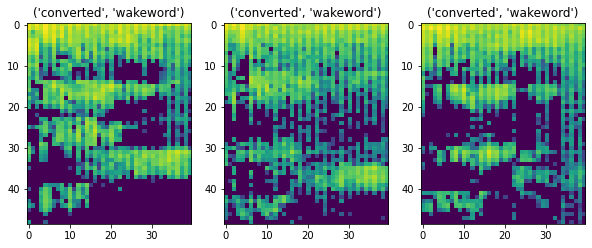

In [ ]:
settings = input_data.standard_microspeech_model_settings(label_count=1)
fig,axes = plt.subplots(ncols=3)
for sample, ax in zip([tilde_ludzu[0], tilde_ludzu[1], tilde_ludzu[2]], axes):
    spectrogram = input_data.file2spec(settings, str(sample)) # PosixPath not supported
    ax.imshow(spectrogram.numpy())
    ax.set_title(sample.parts[:2])
fig.set_size_inches(10,5)

In [ ]:
print(subprocess.check_output(["soxi", tilde_ludzu[2]]).decode("utf8"))


Input File     : 'augumented/converted/dataset/lv/negative/1-AR_USER_2d86c4d2-1a94-444b-b21e-e2e398b6ce7e.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM




# Train wake word recognition model

Load embedding layers

In [ ]:
base_model = tf.keras.models.load_model("./embedding_model/multilingual_context_73_0.8011")
embedding = tf.keras.models.Model(
    name="embedding_model",
    inputs=base_model.inputs,
    outputs=base_model.get_layer(name="dense_2").output,
)
embedding.trainable = False
#embedding.trainable = True

## Test embedding

Check embedding spectrogram

Filepath: augumented/converted/dataset/lv/negative/1-AR_USER_0351642f-8f8d-4071-903f-702fbde6481e.wav
Spectrogram shape (49, 40)
Feature vector shape: (1, 1024)


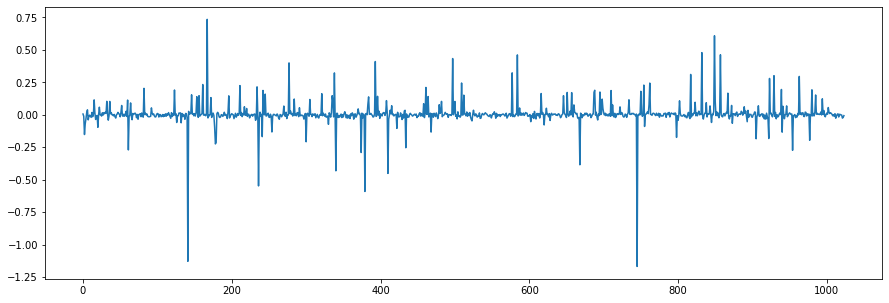

In [ ]:
sample_fpath = str(tilde_ludzu[0])
print("Filepath:", sample_fpath)
spectrogram = input_data.file2spec(settings, sample_fpath)
print("Spectrogram shape", spectrogram.shape)
# retrieve embedding vector representation (reshape into 1x49x40x1)
feature_vec = embedding.predict(spectrogram[tf.newaxis, :, :, tf.newaxis])
print("Feature vector shape:", feature_vec.shape)
plt.plot(feature_vec[0]);
plt.gcf().set_size_inches(15,5)

UMAP visualization

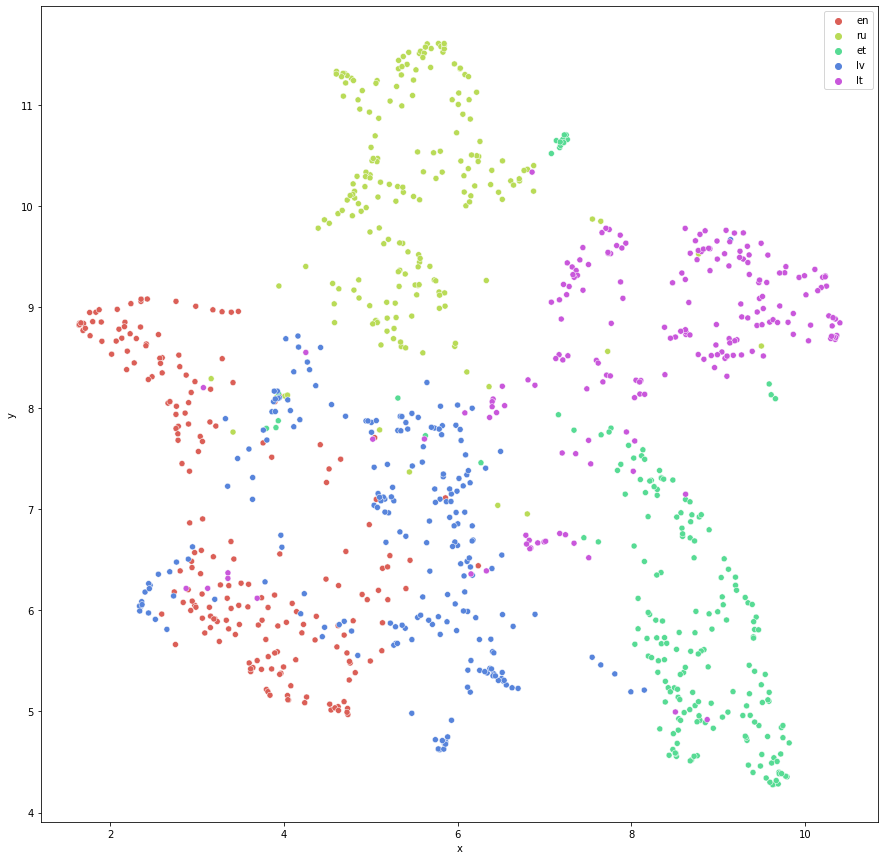

In [ ]:
reducer = umap.UMAP()
wavs = glob.glob("./converted/dataset/*/positive/*.wav")
labels = [w.split("/")[-3] for w in wavs]
spectrograms = np.array([input_data.file2spec(settings, str(w)) for w in wavs])
embeddings = embedding.predict(spectrograms)
scaled_embeddings = sklearn.preprocessing.StandardScaler().fit_transform(embeddings)
projection = reducer.fit_transform(scaled_embeddings)
df = pd.DataFrame(data=dict(x=projection[:,0], y=projection[:, 1], keyword=labels))
kws = set(df.keyword.tolist())
sns.scatterplot(x="x", y="y", hue=df.keyword.tolist(), data=df, palette=sns.color_palette("hls", n_colors=len(kws)))
plt.gcf().set_size_inches(15,15)

## Select data

In [ ]:
from random import sample
import random

LANG="ru"
TRAIN_DEV_SET_KEY_COUNT = 7
TEST_SET_KEY_COUNT = 3

TRAIN_SAMPLES_PER_SPEAKER = 7
TRAIN_SPEAKER_COUNT = 10
#TRAIN_SPEAKER_COUNT = len(get_speaker_set(train_dev_samples))

def key(x):
  fname = x.split("/")[-1]
  part = fname.split("-")[0]
  key = int(part.split("_")[-1])
  return key

def get_key_set(samples):
  result = set()
  for s in samples:
    result.add(key(s))
  return result

def get_speaker(sample):
  fname = sample.split("/")[-1]
  return "-".join(fname.split("-")[1:])

def get_speaker_set(samples):
  result = set()
  for s in samples:
    result.add(get_speaker(s))
  return result

data_location = "."
data_location = "dataset_processed"

all_samples = glob.glob(data_location + "/converted/dataset/" + LANG + "/positive/*.wav")
all_samples.sort(key=key)
keys = get_key_set(all_samples)

near_field_keys = list(keys)[0:10]
far_field_keys = list(keys)[10:20]

allowed_keys = keys
#allowed_keys = near_field_keys
#allowed_keys = far_field_keys

nf_train_dev_samples, ff_train_dev_samples = [], []

def split_train_dev_and_test_samples(samples):
  train_dev_samples, test_samples = [], []
  for s in samples:
    if key(s) not in allowed_keys:
      continue
    nr = (key(s) - 1) % 10
    if nr < TRAIN_DEV_SET_KEY_COUNT :
      if key(s) in near_field_keys:
        nf_train_dev_samples.append(s)
      else:
        ff_train_dev_samples.append(s)
      train_dev_samples.append(s)
    else:
      test_samples.append(s)
  return train_dev_samples, test_samples

train_dev_samples, test_samples = split_train_dev_and_test_samples(all_samples)

train_samples, dev_samples = [], []

def split_train_dev_samples(samples, samples_per_speaker):

  for s in samples:
    speaker = get_speaker(s)
    current_count = len(list(filter(lambda x: get_speaker(x) == speaker, train_samples)))
    train_speakers = get_speaker_set(train_samples)
    train_speakers.add(speaker)
    if current_count < samples_per_speaker and len(train_speakers) <= TRAIN_SPEAKER_COUNT:
      train_samples.append(s)
    else:
      dev_samples.append(s)
  return train_samples, dev_samples

def filter_samples_by_keys(samples):
  return [s for s in samples if key(s) in allowed_keys]


if len(allowed_keys) < len(keys): 
  split_train_dev_samples(filter_samples_by_keys(train_dev_samples), TRAIN_SAMPLES_PER_SPEAKER)
else:
  split_train_dev_samples(nf_train_dev_samples, TRAIN_SAMPLES_PER_SPEAKER)
  split_train_dev_samples(ff_train_dev_samples, 2*TRAIN_SAMPLES_PER_SPEAKER)


unknown_files = glob.glob(data_location + "/converted/*/clips/*/*.wav")

negative_samples = glob.glob(data_location + "/converted/dataset/" + LANG + "/negative/*.wav")

def split_unknown_samples(samples):
  train_dev_unknown, test_unknown = [], []
  speakers = get_speaker_set(samples)
  speaker_count = len(speakers)
  dir = os.path.dirname(samples[0])
  for i in keys:
    first_words = [f"{dir}/1_{i}-{sp}" for sp in speakers]
    second_words = [f"{dir}/2_{i}-{sp}" for sp in speakers]
    third_words = [f"{dir}/{i}-{sp}" for sp in speakers]
    joined = first_words + second_words + third_words
    if i % 2 == 1:
      train_dev_unknown.extend(joined)
    else:
      test_unknown.extend(joined)

  return [x for x in train_dev_unknown if x in samples], [x for x in test_unknown if x in samples]

# use only corresponding near/far field negative samples
negative_samples = filter_samples_by_keys(negative_samples)

negative_train, negative_test = split_unknown_samples(negative_samples)


# add random words (50/50) 
random.seed(1)
unknown_files_train = negative_train + random.sample(unknown_files, len(negative_train))
#unknown_files_train = negative_train
random.shuffle(unknown_files_train)

random.seed(2)
unknown_files_test = negative_test + random.sample([x for x in unknown_files if x not in unknown_files_train], len(negative_test))
#unknown_files_test = negative_test




print("# of total samples", len(all_samples), f" ({str(len(get_speaker_set(all_samples)))} speakers)")
print("# of train samples", len(train_samples), f" ({str(len(get_speaker_set(train_samples)))} speakers)")
print("# of dev samples", len(dev_samples), f" ({str(len(get_speaker_set(dev_samples)))} speakers)")
print("# of test samples", len(test_samples), f" ({str(len(get_speaker_set(test_samples)))} speakers)")


print("")
print("# of train unknown samples", len(unknown_files_train))
print("# of test unknown samples", len(unknown_files_test))

# of total samples 200  (10 speakers)
# of train samples 140  (10 speakers)
# of dev samples 0  (0 speakers)
# of test samples 60  (10 speakers)

# of train unknown samples 600
# of test unknown samples 600


## Add more data (optional)

In [ ]:
other_languages_samples = glob.glob(data_location + "/converted/dataset/*/*/*.wav")
other_languages_samples = [x for x in other_languages_samples if f"/{LANG}/" not in x]
random.shuffle(other_languages_samples)

split = len(other_languages_samples) // 2

unknown_files_train = unknown_files_train + other_languages_samples[:split]
for i in range(10):
  unknown_files_train = unknown_files_train + glob.glob(data_location + "/converted/dataset/noise/*.wav")

unknown_files_test = unknown_files_test + other_languages_samples[split:]
random.shuffle(unknown_files_train)

print("# of train unknown samples", len(unknown_files_train))
print("# of test unknown samples", len(unknown_files_test))

# of train unknown samples 2685
# of test unknown samples 2615


Append augumented near field files to train & dev data

In [ ]:
allowed_keys = near_field_keys

augmentations = [
                 data_location + '/augmented/noise', 
                 data_location + '/augmented/gain',
                 data_location + '/augmented/noise_gain',
                 data_location + '/augmented/room',
                 data_location + '/augmented/noise_room',
                 data_location + '/augmented/gain_room',
                 data_location + '/augmented/noise_gain_room',
                 data_location + '/augmented/ir',
                 data_location + '/augmented/noise_ir',
                 data_location + '/augmented/gain_ir',
                 data_location + '/augmented/noise_gain_ir',
                 data_location + '/augmented/pitch_shift',
                 data_location + '/augmented/normalize',
                 data_location + '/augmented/time_stretch',
                 ]

for i in range(0, len(augmentations)):
  dir = augmentations[i]
  augmented_positive_samples = glob.glob(f"{dir}/converted/dataset/" + LANG + "/positive/*.wav")
  augmented_negative_samples = glob.glob(f"{dir}/converted/dataset/" + LANG + "/negative/*.wav")

  # add to positives to train & dev sets
  more_train_dev_samples, more_test_samples = split_train_dev_and_test_samples(augmented_positive_samples)
  split_train_dev_samples(filter_samples_by_keys(more_train_dev_samples), TRAIN_SAMPLES_PER_SPEAKER * (i+2))

  more_negative_train, more_negative_test = split_unknown_samples(filter_samples_by_keys(augmented_negative_samples))
  unknown_files_train = unknown_files_train + more_negative_train
  random.shuffle(unknown_files_train)

print("# of total samples", len(all_samples), f" ({str(len(get_speaker_set(all_samples)))} speakers)")
print("# of train samples", len(train_samples), f" ({str(len(get_speaker_set(train_samples)))} speakers)")
print("# of dev samples", len(dev_samples), f" ({str(len(get_speaker_set(dev_samples)))} speakers)")
print("# of test samples", len(test_samples), f" ({str(len(get_speaker_set(test_samples)))} speakers)")


print("")
print("# of train unknown samples", len(unknown_files_train))
print("# of test unknown samples", len(unknown_files_test))

# of total samples 200  (10 speakers)
# of train samples 1050  (10 speakers)
# of dev samples 70  (10 speakers)
# of test samples 60  (10 speakers)

# of train unknown samples 4785
# of test unknown samples 2615


Repeat training set

In [ ]:
repeat_times = (len(unknown_files_train) // len(train_samples)) - 1
add = train_samples
for i in range(repeat_times):
  train_samples = train_samples + add

print("# of total samples", len(all_samples), f" ({str(len(get_speaker_set(all_samples)))} speakers)")
print("# of train samples", len(train_samples), f" ({str(len(get_speaker_set(train_samples)))} speakers)")
print("# of dev samples", len(dev_samples), f" ({str(len(get_speaker_set(dev_samples)))} speakers)")
print("# of test samples", len(test_samples), f" ({str(len(get_speaker_set(test_samples)))} speakers)")


print("")
print("# of train unknown samples", len(unknown_files_train))
print("# of test unknown samples", len(unknown_files_test))

# of total samples 200  (10 speakers)
# of train samples 4200  (10 speakers)
# of dev samples 70  (10 speakers)
# of test samples 60  (10 speakers)

# of train unknown samples 4785
# of test unknown samples 2615


## Train

In [ ]:
KEYWORD = "TildePls_" + LANG

background_noise = "/content/speech_commands/_background_noise_/"


print("---Training model---")
model_settings = input_data.standard_microspeech_model_settings(3)
_, model, _ = transfer_learning.transfer_learn(
    target=KEYWORD,
    train_files=train_samples,
    val_files=dev_samples,
    #val_files=[train_samples[0]],
    unknown_files=unknown_files_train,
    #num_epochs=4,
    num_epochs=8,
    num_batches=1,
    batch_size=64,
    primary_lr=0.001,
    # backprop_into_embedding=False,
    # embedding_lr=0,
    backprop_into_embedding=True,
    embedding_lr=0.001,
    model_settings=model_settings,
    base_model_path="embedding_model/multilingual_context_73_0.8011",
    base_model_output="dense_2",
    UNKNOWN_PERCENTAGE=50.0,
    bg_datadir=background_noise,
    csvlog_dest=None,
)
model.save(f"{KEYWORD}_{len(train_samples)}shot")

---Training model---


Epoch 1/8
64/64 [==============================] - 31s 351ms/step - loss: 0.5291 - accuracy: 0.8425 - val_loss: 0.1777 - val_accuracy: 0.9857
Epoch 2/8
64/64 [==============================] - 22s 338ms/step - loss: 0.2834 - accuracy: 0.9019 - val_loss: 0.1327 - val_accuracy: 0.9714
Epoch 3/8
64/64 [==============================] - 20s 317ms/step - loss: 0.2449 - accuracy: 0.9106 - val_loss: 0.1304 - val_accuracy: 0.9714
Epoch 4/8
64/64 [==============================] - 20s 317ms/step - loss: 0.2214 - accuracy: 0.9187 - val_loss: 0.1469 - val_accuracy: 0.9571
Epoch 5/8
64/64 [==============================] - 20s 315ms/step - loss: 0.1969 - accuracy: 0.9282 - val_loss: 0.1040 - val_accuracy: 0.9857
Epoch 6/8
64/64 [==============================] - 20s 314ms/step - loss: 0.1972 - accuracy: 0.9263 - val_loss: 0.0894 - val_accuracy: 0.9714
Epoch 7/8
64/64 [==============================] - 20s 314ms/step - loss: 0.1870 - accuracy: 0.9277 - val_loss: 0.0994 - val_accuracy: 0.9714
Epoch 

INFO:tensorflow:Assets written to: TildePls_ru_4200shot/assets


INFO:tensorflow:Assets written to: TildePls_ru_4200shot/assets


## Evaluate

Use threshold

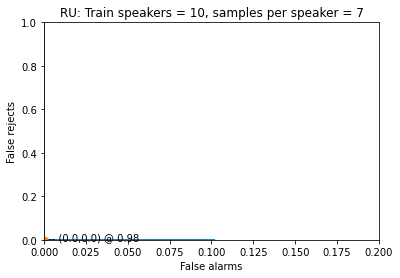

AUC: 3,1867431485022306e-06


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

prediction_model = model
prediction_model = distiller.student

THRESHOLD_STEP=0.001
THRESHOLD_START=0.01
THRESHOLD_END=0.999
MAX_ACCEPTABLE_FALSE_ALARM=0.02

false_alarms = []
false_rejects = []
true_positives = []
min_fa = 1
min_fr = 1
best_threshold = 0

target_examples = test_samples
settings = input_data.standard_microspeech_model_settings(label_count=1)
target_spectrograms = np.array([input_data.file2spec(settings, str(f)) for f in target_examples])
target_predictions = prediction_model.predict(target_spectrograms)

non_target_examples = unknown_files_test
non_target_spectrograms = np.array([input_data.file2spec(settings, str(f)) for f in non_target_examples])
non_target_predictions = prediction_model.predict(non_target_spectrograms)

for threshold in np.arange(THRESHOLD_START, THRESHOLD_END, THRESHOLD_STEP):
  negative_count = 0
  for p in target_predictions:
    if p[2] < threshold:
      negative_count += 1
  false_negative_rate = negative_count / len(target_examples)
  false_rejects.append(false_negative_rate)
  true_positives.append(1-false_negative_rate)

  positive_count = 0
  for p in non_target_predictions:
    if p[2] >= threshold:
      positive_count += 1

  false_positive_rate = positive_count / len(non_target_examples)
  false_alarms.append(false_positive_rate)
  #print(f"False positive rate: {false_positive_rate:0.2f}")

for i in range(0, len(false_alarms)):
  fa = false_alarms[i]
  fr = false_rejects[i]
  if fa <= MAX_ACCEPTABLE_FALSE_ALARM and fr <= min_fr and fa < min_fa:
    min_fa = fa
    min_fr = fr
    best_threshold = THRESHOLD_START + (THRESHOLD_STEP * i)

auc_val = auc(false_alarms, false_rejects)

plt.plot(np.array(false_alarms), np.array(false_rejects))
plt.title(f"{LANG.upper()}: Train speakers = {TRAIN_SPEAKER_COUNT}, samples per speaker = {TRAIN_SAMPLES_PER_SPEAKER}")
plt.xlabel("False alarms") 
plt.ylabel("False rejects")
plt.ylim(0.0, 1.0)
plt.xlim(0.0, 0.2)
#plt.xticks(np.arange(0.0, 0.10, 0.01))
#plt.yticks(np.arange(0.0, 0.8, 0.1))

plt.plot([min_fa], [min_fr], ls="", marker="o", label="points")
plt.text(min_fa, min_fr, f" -- ({round(min_fa, 3)},{round(min_fr, 3)}) @ {round(best_threshold, 2)}")

plt.show()

print("AUC: " + str(auc_val).replace(".", ","))

#print(f"MIN false alarm: {min(false_alarms)}")

Archive & download model

In [ ]:
model_dir = f"/content/TildePls_{LANG}_{str(len(train_samples))}shot"
model_dir = "/content/TildePls_ru_4200shot_distilled"

zip_name = f'{model_dir}.zip'
!zip -r $zip_name $model_dir
from google.colab import files
files.download(zip_name) 

  adding: content/TildePls_ru_4200shot_distilled/ (stored 0%)
  adding: content/TildePls_ru_4200shot_distilled/saved_model.pb (deflated 91%)
  adding: content/TildePls_ru_4200shot_distilled/variables/ (stored 0%)
  adding: content/TildePls_ru_4200shot_distilled/variables/variables.index (deflated 74%)
  adding: content/TildePls_ru_4200shot_distilled/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/TildePls_ru_4200shot_distilled/assets/ (stored 0%)
  adding: content/TildePls_ru_4200shot_distilled/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Knowledge distillation

In [ ]:
model_name = "TildePls_lt_4044shot" #@param {type:"string"}
model_name = "content/" + model_name
zip_name = f"{model_name}.zip"
#!unzip $zip_name

In [ ]:
model = tf.keras.models.load_model(model_name)

In [ ]:
from tensorflow import keras

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
import logging
from keras import layers, models

teacher = model

trained_base_model = tf.keras.models.load_model("embedding_model/multilingual_context_73_0.8011")

x = trained_base_model.layers[-6].output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
# layers.Dropout(0.5)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, kernel_initializer="lecun_normal", activation="selu")(x)
# must use alpha-dropout if dropout is desired with selu
logits = layers.Dense(3)(x)

embedding_model = models.Model(inputs=trained_base_model.input, outputs=logits)
embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
embedding_model.summary()
xfer = tf.keras.models.Model(
    name="EmbeddingModel",
    inputs=embedding_model.inputs,
    outputs=embedding_model.layers[-1].output,
)
#xfer.trainable = False

# dont use softmax unless losses from_logits=False
CATEGORIES = 3  # silence + unknown + target_keyword
student = tf.keras.models.Sequential(
    [
        xfer,
        tf.keras.layers.Dense(units=18, activation="tanh"),
        tf.keras.layers.Dense(units=CATEGORIES, activation="softmax"),
    ],
    name="student"
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 49, 40, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 49, 40, 1)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 49, 40, 1)    3           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 51, 41, 1)    0           ['normalization[0][0]']          
                                                                                            

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    #metrics=[keras.metrics.SparseCategoricalAccuracy()],
    metrics=["accuracy"],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

In [ ]:
audio_dataset = input_data.AudioDataset(
        model_settings=model_settings,
        commands=[KEYWORD],
        background_data_dir=background_noise,
        unknown_files=unknown_files_train,
        unknown_percentage=50.0,
        spec_aug_params=input_data.SpecAugParams(percentage=80),
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
init_train_ds = audio_dataset.init_single_target(
    AUTOTUNE, train_samples, is_training=True
)
init_val_ds = audio_dataset.init_single_target(
    AUTOTUNE, dev_samples, is_training=False
)
train_ds = init_train_ds.shuffle(buffer_size=1000).repeat().batch(64)
val_ds = init_val_ds.batch(64)
print(type(distiller))

small_model = distiller.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=64 * 1,
    #epochs=4,
    epochs=8,
    callbacks=[],
    verbose=True,
)

<class '__main__.Distiller'>
Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


64/64 [==============================] - 104s 1s/step - accuracy: 0.8870 - student_loss: 0.3499 - distillation_loss: 2.9993e-04 - val_accuracy: 1.0000 - val_student_loss: 0.2803
Epoch 2/8
64/64 [==============================] - 83s 1s/step - accuracy: 0.9863 - student_loss: 0.0675 - distillation_loss: 4.4768e-05 - val_accuracy: 0.9857 - val_student_loss: 0.1541
Epoch 3/8
64/64 [==============================] - 83s 1s/step - accuracy: 0.9885 - student_loss: 0.0481 - distillation_loss: 3.1641e-05 - val_accuracy: 1.0000 - val_student_loss: 0.0413
Epoch 4/8
64/64 [==============================] - 83s 1s/step - accuracy: 0.9878 - student_loss: 0.0465 - distillation_loss: 3.5774e-05 - val_accuracy: 0.9571 - val_student_loss: 0.0346
Epoch 5/8
64/64 [==============================] - 80s 1s/step - accuracy: 0.9915 - student_loss: 0.0323 - distillation_loss: 2.9677e-05 - val_accuracy: 1.0000 - val_student_loss: 0.0123
Epoch 6/8
64/64 [==============================] - 80s 1s/step - accuracy:

In [ ]:
distiller.teacher.summary()
distiller.student.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TransferLearnedModel (Funct  (None, 1024)             12967007  
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 18)                18450     
                                                                 
 dense_13 (Dense)            (None, 3)                 57        
                                                                 
Total params: 12,985,514
Trainable params: 12,943,495
Non-trainable params: 42,019
_________________________________________________________________
Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingModel (Functional)  (None, 3)                4243042   
                    

In [ ]:
distiller.student.save(f"{KEYWORD}_{len(train_samples)}shot_distilled")

INFO:tensorflow:Assets written to: TildePls_ru_4200shot_distilled/assets


INFO:tensorflow:Assets written to: TildePls_ru_4200shot_distilled/assets
